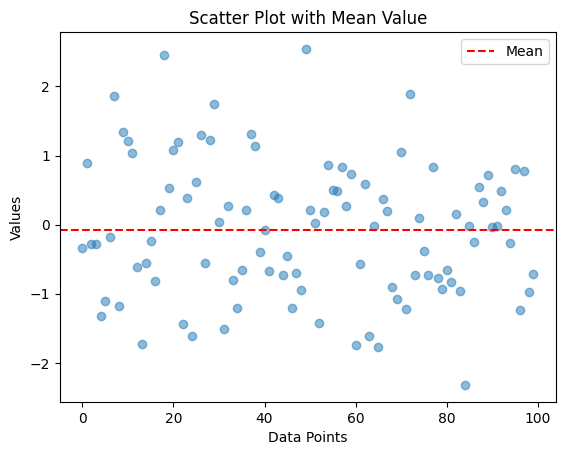

In [1]:
import matplotlib.pyplot as plt
import numpy as np

# Generate sample data
data = np.random.randn(100)

# Calculate the mean value
mean_value = np.mean(data)

# Plot the data with alpha level
plt.scatter(range(len(data)), data, alpha=0.5)

# Add a horizontal line for the mean value
plt.axhline(mean_value, color='red', linestyle='--', label='Mean')

# Set plot properties
plt.xlabel('Data Points')
plt.ylabel('Values')
plt.title('Scatter Plot with Mean Value')
plt.legend()

# Display the plot
plt.show()

# 程式 3.1: 建立一個Gridworld遊戲

In [2]:
# 下載 Gridworld.py 及 GridBoard.py (-q 是設為安靜模式)
# !wget -q https://github.com/DeepReinforcementLearning/DeepReinforcementLearningInAction/raw/master/Errata/Gridworld.py
# !wget -q https://github.com/DeepReinforcementLearning/DeepReinforcementLearningInAction/raw/master/Errata/GridBoard.py

from Gridworld import Gridworld
game = Gridworld(size=4, mode='static')

In [3]:
game.display()

array([['+', '-', ' ', 'P'],
       [' ', 'W', ' ', ' '],
       [' ', ' ', ' ', ' '],
       [' ', ' ', ' ', ' ']], dtype='<U2')

In [4]:
game.makeMove('d')

In [5]:
game.display()

array([['+', '-', ' ', ' '],
       [' ', 'W', ' ', 'P'],
       [' ', ' ', ' ', ' '],
       [' ', ' ', ' ', ' ']], dtype='<U2')

In [6]:
game.reward()

-1

In [7]:
game.board.render_np()

array([[[0, 0, 0, 0],
        [0, 0, 0, 1],
        [0, 0, 0, 0],
        [0, 0, 0, 0]],

       [[1, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]],

       [[0, 1, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]],

       [[0, 0, 0, 0],
        [0, 1, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]]], dtype=uint8)

In [8]:
game.board.render_np().shape

(4, 4, 4)

# 程式 3.2

In [9]:
import numpy as np
import torch
from Gridworld import Gridworld
from IPython.display import clear_output
import random
from matplotlib import pylab as plt

L1 = 64 #輸入層的寬度
L2 = 150 #第一隱藏層的寬度
L3 = 100 #第二隱藏層的寬度
L4 = 4 #輸出層的寬度


import torch.nn as nn

class DuelingDQN(nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, output_dim):
        super(DuelingDQN, self).__init__()
        self.feature = nn.Sequential(
            nn.Linear(input_dim, hidden_dim1),
            nn.ReLU(),
            nn.Linear(hidden_dim1, hidden_dim2),
            nn.ReLU()
        )
        self.value_stream = nn.Sequential(
            nn.Linear(hidden_dim2, 1)
        )
        self.advantage_stream = nn.Sequential(
            nn.Linear(hidden_dim2, output_dim)
        )

    def forward(self, x):
        x = self.feature(x)
        value = self.value_stream(x)
        advantage = self.advantage_stream(x)
        q_vals = value + (advantage - advantage.mean(dim=1, keepdim=True))
        return q_vals

model = DuelingDQN(L1, L2, L3, L4)


##將動作的字母與數字對應起來

In [10]:
action_set = {
	0: 'u', #『0』代表『向上』
	1: 'd', #『1』代表『向下』
	2: 'l', #『2』代表『向左』
	3: 'r' #『3』代表『向右』
}

# 程式 3.3: 主要訓練迴圈

In [11]:
import torch.nn.functional as F

target_model = DuelingDQN(L1, L2, L3, L4)
target_model.load_state_dict(model.state_dict())
target_model.eval()

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
gamma = 0.9
epsilon = 0.1
target_update = 10

epochs = 1000
losses = []

for i in range(epochs):
    game = Gridworld(size=4, mode='static')
    state_ = game.board.render_np().reshape(1,64) + np.random.rand(1,64)/10.0
    state1 = torch.from_numpy(state_).float()
    status = 1

    while(status == 1):
        qval = model(state1)
        qval_ = qval.data.numpy()
        if random.random() < epsilon:
            action_ = np.random.randint(0,4)
        else:
            action_ = np.argmax(qval_)

        action = action_set[action_]
        game.makeMove(action)
        state2_ = game.board.render_np().reshape(1,64) + np.random.rand(1,64)/10.0
        state2 = torch.from_numpy(state2_).float()
        reward = game.reward()

        with torch.no_grad():
            next_action = torch.argmax(model(state2)).unsqueeze(0)
            next_q_value = target_model(state2).gather(1, next_action.unsqueeze(1)).squeeze()

        Y = reward + gamma * next_q_value if reward != -10 and reward != 10 else reward
        Y = torch.tensor([Y], dtype=torch.float32)
        output = model(state1)[0][action_]
        loss = F.mse_loss(output, Y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        state1 = state2
        if reward != -1:
            status = 0
            losses.append(loss.item())

    if i % target_update == 0:
        target_model.load_state_dict(model.state_dict())


loss_fn = torch.nn.MSELoss()  # 定義損失函數

C:\Users\user\AppData\Local\Temp\ipykernel_10260\1878552179.py:42: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(output, Y)


##torch.no_grad的效果說明

In [12]:
m = torch.Tensor([2.0])
m.requires_grad=True
b = torch.Tensor([1.0]) 
b.requires_grad=True
def linear_model(x,m,b):
  y = m*x + b
  return y
y = linear_model(torch.Tensor([4.]),m,b)
y

tensor([9.], grad_fn=<AddBackward0>)

In [13]:
y.grad_fn

In [14]:
with torch.no_grad(): 
  y = linear_model(torch.Tensor([4.]),m,b)
y

tensor([9.])

In [15]:
y.grad_fn

In [16]:
y = linear_model(torch.Tensor([4.]),m,b)
y.backward()
m.grad

tensor([4.])

In [17]:
b.grad

tensor([1.])

# 程式 3.4： 測試Q網路

In [18]:
def test_model(model, mode='static', display=True):
    i = 0
    test_game = Gridworld(size=4, mode=mode) #產生一場測試遊戲
    state_ = test_game.board.render_np().reshape(1,64) + np.random.rand(1,64)/10.0
    state = torch.from_numpy(state_).float()
    if display:
      print("Initial State:")
      print(test_game.display())
    status = 1
    while(status == 1): #遊戲仍在進行
      qval = model(state)
      qval_ = qval.data.numpy()
      action_ = np.argmax(qval_) 
      action = action_set[action_]
      if display:
        print('Move #: %s; Taking action: %s' % (i, action))
      test_game.makeMove(action)
      state_ = test_game.board.render_np().reshape(1,64) + np.random.rand(1,64)/10.0
      state = torch.from_numpy(state_).float()
      if display:
        print(test_game.display())
      reward = test_game.reward()
      if reward != -1: #代表勝利（抵達終點）或落敗（掉入陷阱）
        if reward > 0: #reward>0，代表成功抵達終點
          status = 2 #將狀態設為2，跳出迴圈
          if display:
            print("Game won! Reward: %s" %reward)
          else: #掉入陷阱
            status = 0 #將狀態設為0，跳出迴圈
            if display:
              print("Game LOST. Reward: %s" %reward)
      i += 1 #每移動一步，i就加1
      if (i > 15): #若移動了15步，仍未取出勝利，則一樣視為落敗
        if display:
          print("Game lost; too many moves.")
        break    
    win = True if status == 2 else False
    print(win)
    return win

## 測試模型（static mode)

In [19]:
test_model(model, 'static')

Initial State:
[['+' '-' ' ' 'P']
 [' ' 'W' ' ' ' ']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 0; Taking action: d
[['+' '-' ' ' ' ']
 [' ' 'W' ' ' 'P']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 1; Taking action: d
[['+' '-' ' ' ' ']
 [' ' 'W' ' ' ' ']
 [' ' ' ' ' ' 'P']
 [' ' ' ' ' ' ' ']]
Move #: 2; Taking action: l
[['+' '-' ' ' ' ']
 [' ' 'W' ' ' ' ']
 [' ' ' ' 'P' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 3; Taking action: l
[['+' '-' ' ' ' ']
 [' ' 'W' ' ' ' ']
 [' ' 'P' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 4; Taking action: l
[['+' '-' ' ' ' ']
 [' ' 'W' ' ' ' ']
 ['P' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 5; Taking action: u
[['+' '-' ' ' ' ']
 ['P' 'W' ' ' ' ']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 6; Taking action: u
[['+' '-' ' ' ' ']
 [' ' 'W' ' ' ' ']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Game won! Reward: 10
True


True

## 測試模型 (random mode）

In [20]:
test_model(model, 'random') #將游戲的生成模式改成random，再次測試模型

Initial State:
[[' ' ' ' ' ' 'P']
 [' ' 'W' ' ' ' ']
 [' ' ' ' ' ' ' ']
 ['-' '+' ' ' ' ']]
Move #: 0; Taking action: d
[[' ' ' ' ' ' ' ']
 [' ' 'W' ' ' 'P']
 [' ' ' ' ' ' ' ']
 ['-' '+' ' ' ' ']]
Move #: 1; Taking action: d
[[' ' ' ' ' ' ' ']
 [' ' 'W' ' ' ' ']
 [' ' ' ' ' ' 'P']
 ['-' '+' ' ' ' ']]
Move #: 2; Taking action: l
[[' ' ' ' ' ' ' ']
 [' ' 'W' ' ' ' ']
 [' ' ' ' 'P' ' ']
 ['-' '+' ' ' ' ']]
Move #: 3; Taking action: l
[[' ' ' ' ' ' ' ']
 [' ' 'W' ' ' ' ']
 [' ' 'P' ' ' ' ']
 ['-' '+' ' ' ' ']]
Move #: 4; Taking action: l
[[' ' ' ' ' ' ' ']
 [' ' 'W' ' ' ' ']
 ['P' ' ' ' ' ' ']
 ['-' '+' ' ' ' ']]
Move #: 5; Taking action: u
[[' ' ' ' ' ' ' ']
 ['P' 'W' ' ' ' ']
 [' ' ' ' ' ' ' ']
 ['-' '+' ' ' ' ']]
Move #: 6; Taking action: u
[['P' ' ' ' ' ' ']
 [' ' 'W' ' ' ' ']
 [' ' ' ' ' ' ' ']
 ['-' '+' ' ' ' ']]
Move #: 7; Taking action: u
[['P' ' ' ' ' ' ']
 [' ' 'W' ' ' ' ']
 [' ' ' ' ' ' ' ']
 ['-' '+' ' ' ' ']]
Move #: 8; Taking action: u
[['P' ' ' ' ' ' ']
 [' ' 'W' ' ' ' ']
 [

False

## 將程式3.3的遊戲生成模式改成random，並進行1000次訓練

Text(0, 0.5, 'Loss')

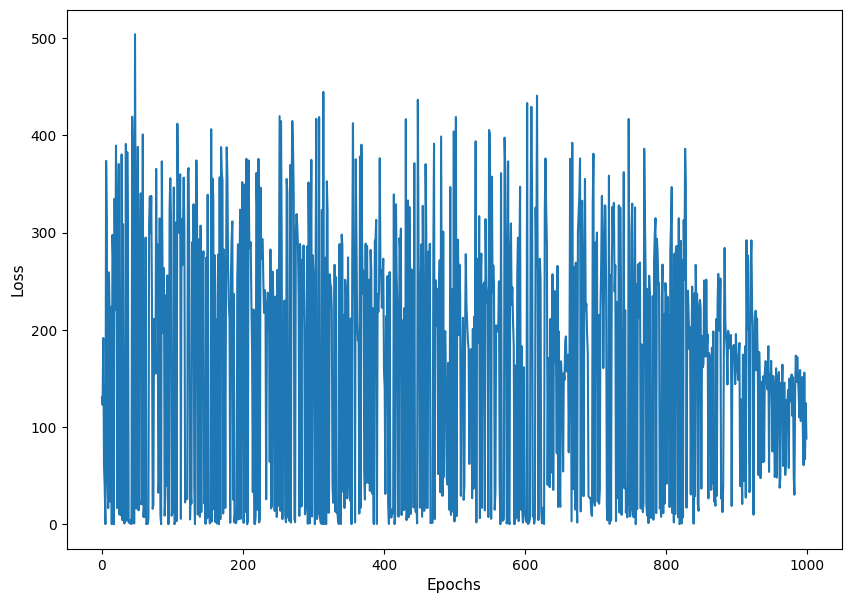

In [21]:
epochs = 1000
losses = [] #使用串列將每一次的loss記錄下來，方便之後將loss的變化趨勢畫成圖
for i in range(epochs):
  game = Gridworld(size=4, mode='random')
  state_ = game.board.render_np().reshape(1,64) + np.random.rand(1,64)/10.0 #將3階的狀態陣列（4x4x4）轉換成向量（長度為64），並將每個值都加上一些雜訊（很小的數值）。	
  state1 = torch.from_numpy(state_).float() #將NumPy陣列轉換成PyTorch張量，並存於state1中
  status = 1 #用來追蹤遊戲是否仍在繼續（『1』代表仍在繼續）
  while(status == 1):
    qval = model(state1) #執行Q網路，取得所有動作的預測Q值
    qval_ = qval.data.numpy() #將qval轉換成NumPy陣列
    if (random.random() < epsilon): 
      action_ = np.random.randint(0,4) #隨機選擇一個動作（探索）
    else:
      action_ = np.argmax(qval_) #選擇Q值最大的動作（探索）        
    action = action_set[action_] #將代表某動作的數字對應到makeMove()的英文字母
    game.makeMove(action) #執行之前ε—貪婪策略所選出的動作 
    state2_ = game.board.render_np().reshape(1,64) + np.random.rand(1,64)/10.0
    state2 = torch.from_numpy(state2_).float() #動作執行完畢，取得遊戲的新狀態並轉換成張量
    reward = game.reward()
    with torch.no_grad(): 
      newQ = model(state2.reshape(1,64))
    maxQ = torch.max(newQ) #將新狀態下所輸出的Q值向量中的最大值給記錄下來
    if reward == -1:
      Y = reward + (gamma * maxQ)  #計算訓練所用的目標Q值
    else: #若reward不等於-1，代表遊戲已經結束，也就沒有下一個狀態了，因此目標Q值就等於回饋值
      Y = reward
    Y = torch.Tensor([Y]).detach() 
    X = qval.squeeze()[action_] #將演算法對執行的動作所預測的Q值存進X，並使用squeeze()將qval中維度為1的階去掉 (shape[1,4]會變成[4])
    loss = loss_fn(X, Y) #計算目標Q值與預測Q值之間的誤差
    if i%100 == 0:
      print(i, loss.item())
      clear_output(wait=True)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    state1 = state2
    if abs(reward) == 10:       
      status = 0 # 若 reward 的絕對值為10，代表遊戲已經分出勝負，所以設status為0  
  losses.append(loss.item())
  if epsilon > 0.1: 
    epsilon -= (1/epochs) #讓ε的值隨著訓練的進行而慢慢下降，直到0.1（還是要保留探索的動作）
plt.figure(figsize=(10,7))
plt.plot(losses)
plt.xlabel("Epochs",fontsize=11)
plt.ylabel("Loss",fontsize=11)

## 將程式3.3的遊戲生成模式改成player，並進行1000次訓練

Text(0, 0.5, 'Loss')

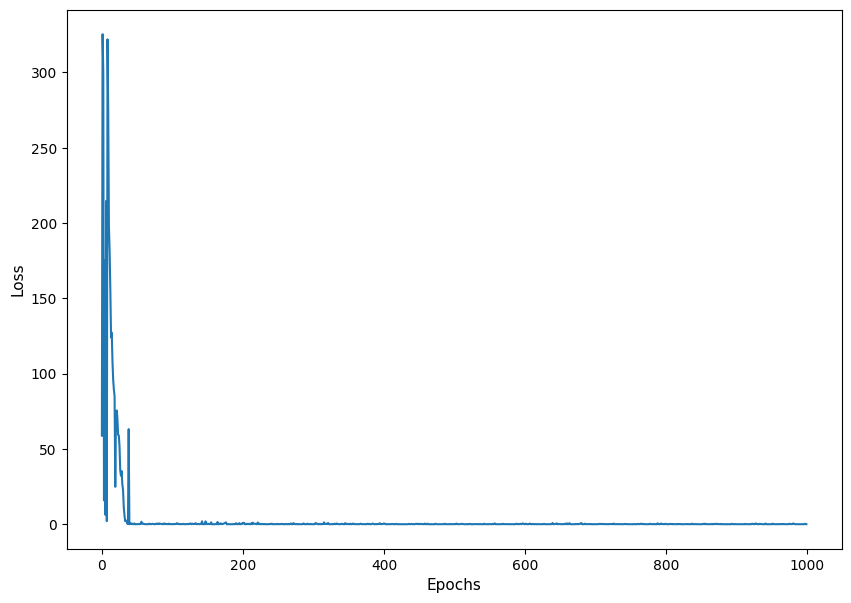

In [22]:
epochs = 1000
losses = [] #使用串列將每一次的loss記錄下來，方便之後將loss的變化趨勢畫成圖
for i in range(epochs):
  game = Gridworld(size=4, mode='player')
  state_ = game.board.render_np().reshape(1,64) + np.random.rand(1,64)/10.0 #將3階的狀態陣列（4x4x4）轉換成向量（長度為64），並將每個值都加上一些雜訊（很小的數值）。	
  state1 = torch.from_numpy(state_).float() #將NumPy陣列轉換成PyTorch張量，並存於state1中
  status = 1 #用來追蹤遊戲是否仍在繼續（『1』代表仍在繼續）
  while(status == 1):
    qval = model(state1) #執行Q網路，取得所有動作的預測Q值
    qval_ = qval.data.numpy() #將qval轉換成NumPy陣列
    if (random.random() < epsilon): 
      action_ = np.random.randint(0,4) #隨機選擇一個動作（探索）
    else:
      action_ = np.argmax(qval_) #選擇Q值最大的動作（探索）        
    action = action_set[action_] #將代表某動作的數字對應到makeMove()的英文字母
    game.makeMove(action) #執行之前ε—貪婪策略所選出的動作 
    state2_ = game.board.render_np().reshape(1,64) + np.random.rand(1,64)/10.0
    state2 = torch.from_numpy(state2_).float() #動作執行完畢，取得遊戲的新狀態並轉換成張量
    reward = game.reward()
    with torch.no_grad(): 
      newQ = model(state2.reshape(1,64))
    maxQ = torch.max(newQ) #將新狀態下所輸出的Q值向量中的最大值給記錄下來
    if reward == -1:
      Y = reward + (gamma * maxQ)  #計算訓練所用的目標Q值
    else: #若reward不等於-1，代表遊戲已經結束，也就沒有下一個狀態了，因此目標Q值就等於回饋值
      Y = reward
    Y = torch.Tensor([Y]).detach() 
    X = qval.squeeze()[action_] #將演算法對執行的動作所預測的Q值存進X，並使用squeeze()將qval中維度為1的階去掉 (shape[1,4]會變成[4])
    loss = loss_fn(X, Y) #計算目標Q值與預測Q值之間的誤差
    if i%100 == 0:
      print(i, loss.item())
      clear_output(wait=True)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    state1 = state2
    if abs(reward) == 10:       
      status = 0 # 若 reward 的絕對值為10，代表遊戲已經分出勝負，所以設status為0  
  losses.append(loss.item())
  if epsilon > 0.1: 
    epsilon -= (1/epochs) #讓ε的值隨著訓練的進行而慢慢下降，直到0.1（還是要保留探索的動作）
plt.figure(figsize=(10,7))
plt.plot(losses)
plt.xlabel("Epochs",fontsize=11)
plt.ylabel("Loss",fontsize=11)

## 重建模型（同程式3.2）

In [23]:
import numpy as np
import torch
from Gridworld import Gridworld
from IPython.display import clear_output
import random
from matplotlib import pylab as plt

L1 = 64 #輸入層的寬度
L2 = 150 #第一隱藏層的寬度
L3 = 100 #第二隱藏層的寬度
L4 = 4 #輸出層的寬度

model = torch.nn.Sequential(
    torch.nn.Linear(L1, L2), #第一隱藏層的shape 
    torch.nn.ReLU(),
    torch.nn.Linear(L2, L3), #第二隱藏層的shape
    torch.nn.ReLU(),
    torch.nn.Linear(L3,L4) #輸出層的shape
)
loss_fn = torch.nn.MSELoss() #指定損失函數為MSE（均方誤差）
learning_rate = 1e-3  #設定學習率
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) #指定優化器為Adam，其中model.parameters會傳回所有要優化的權重參數

gamma = 0.9 #折扣因子
epsilon = 1.0

# 程式 3.5: 包含經驗回放的DQN

Text(0, 0.5, 'Loss')

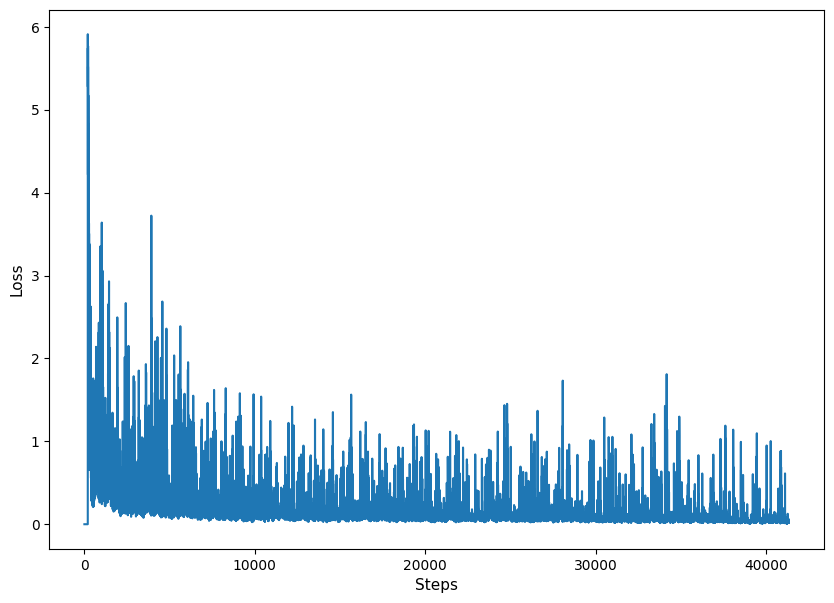

In [24]:
from collections import deque
epochs = 5000 #訓練5000次
losses = []
mem_size = 1000 #設定記憶串列的大小
batch_size = 200 #設定單一小批次（mini_batch）的大小
replay = deque(maxlen=mem_size) #產生一個記憶串列（資料型別為deque）來儲存經驗回放的資料，並將其命名為replay
max_moves = 50 #設定每場遊戲最多可以走幾步
for i in range(epochs):
  game = Gridworld(size=4, mode='random')
  state1_ = game.board.render_np().reshape(1,64) + np.random.rand(1,64)/100.0
  state1 = torch.from_numpy(state1_).float()
  status = 1
  mov = 0 #記錄移動的步數，初始化為0
  while(status == 1): 
    mov += 1
    qval = model(state1) #輸出各動作的Q值
    qval_ = qval.data.numpy()
    if (random.random() < epsilon):
      action_ = np.random.randint(0,4)
    else:
      action_ = np.argmax(qval_)     
    action = action_set[action_]
    game.makeMove(action)
    state2_ = game.board.render_np().reshape(1,64) + np.random.rand(1,64)/100.0
    state2 = torch.from_numpy(state2_).float()
    reward = game.reward()
    done = True if reward != -1 else False #在reward不等於-1時設定done=True，代表遊戲已經結束了（分出勝負時，reward會等於10或-10）
    exp = (state1, action_, reward, state2, done) #產生一筆經驗，其中包含當前狀態、動作、新狀態、回饋值及done值
    replay.append(exp) #將該經驗加入名為replay的deque串列中
    state1 = state2 #產生的新狀態會變成下一次訓練時的輸入狀態      
    if len(replay) > batch_size: #當replay的長度大於小批次量（mini-batch size）時，啟動小批次訓練
      minibatch = random.sample(replay, batch_size) #隨機選擇replay中的資料來組成子集
      state1_batch = torch.cat([s1 for (s1,a,r,s2,d) in minibatch]) #將經驗中的不同元素分別儲存到對應的小批次張量中
      action_batch = torch.Tensor([a for (s1,a,r,s2,d) in minibatch])
      reward_batch = torch.Tensor([r for (s1,a,r,s2,d) in minibatch])
      state2_batch = torch.cat([s2 for (s1,a,r,s2,d) in minibatch]) 
      done_batch = torch.Tensor([d for (s1,a,r,s2,d) in minibatch])            
      Q1 = model(state1_batch) #利用小批次資料中的『目前狀態批次』來計算Q值3
      with torch.no_grad():
        Q2 = model(state2_batch) #利用小批次資料中的新狀態來計算Q值，但設定為不需要計算梯度         
      Y = reward_batch + gamma * ((1 - done_batch) * torch.max(Q2,dim=1)[0]) #計算我們希望DQN學習的目標Q值
      X = Q1.gather(dim=1,index=action_batch.long().unsqueeze(dim=1)).squeeze() 
      loss = loss_fn(X, Y.detach())
      print(i, loss.item())
      clear_output(wait=True)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
    if abs(reward) == 10 or mov > max_moves:
      status = 0
      mov = 0 #若遊戲結束，則重設status和mov變數的值
    losses.append(loss.item())
  if epsilon > 0.1: 
    epsilon -= (1/epochs) #讓ε的值隨著訓練的進行而慢慢下降，直到0.1（還是要保留探索的動作）
losses = np.array(losses)
plt.figure(figsize=(10,7))
plt.plot(losses)
plt.xlabel("Steps",fontsize=11)
plt.ylabel("Loss",fontsize=11)

## 小編補充：gather()和unsqueeze()的函式說明

In [25]:
t = torch.Tensor([ [1, 2, 3],
          [4, 5, 6],
          [7, 8, 9]])
indices = torch.Tensor([ [2],
            [0],
            [1]])
torch.gather(input=t,dim=1,index=indices.long())

tensor([[3.],
        [4.],
        [8.]])

In [26]:
x = torch.tensor([1,2,3,4])
y = torch.unsqueeze(input=x, dim=0) #在x張量的第0階加入一個1維的階
print(y.shape)

torch.Size([1, 4])


# 程式 3.6：測試具備經驗回放機制的模型

In [27]:
max_games = 1000 #模擬1000次遊戲
wins = 0
for i in range(max_games):
  win = test_model(model, mode='random') #利用random模式來進行測試
  if win:
    wins += 1
win_perc = float(wins) / float(max_games)
print("Games played: {0}, # of wins: {1}".format(max_games,wins))
print("Win percentage: {}%".format(100.0*win_perc)) #顯示勝率

Initial State:
[['W' 'P' ' ' ' ']
 [' ' ' ' ' ' ' ']
 [' ' ' ' '-' ' ']
 ['+' ' ' ' ' ' ']]
Move #: 0; Taking action: d
[['W' ' ' ' ' ' ']
 [' ' 'P' ' ' ' ']
 [' ' ' ' '-' ' ']
 ['+' ' ' ' ' ' ']]
Move #: 1; Taking action: d
[['W' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']
 [' ' 'P' '-' ' ']
 ['+' ' ' ' ' ' ']]
Move #: 2; Taking action: l
[['W' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']
 ['P' ' ' '-' ' ']
 ['+' ' ' ' ' ' ']]
Move #: 3; Taking action: d
[['W' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']
 [' ' ' ' '-' ' ']
 ['+' ' ' ' ' ' ']]
Game won! Reward: 10
True
Initial State:
[[' ' 'P' ' ' ' ']
 [' ' ' ' '-' ' ']
 ['W' ' ' ' ' ' ']
 [' ' ' ' '+' ' ']]
Move #: 0; Taking action: r
[[' ' ' ' 'P' ' ']
 [' ' ' ' '-' ' ']
 ['W' ' ' ' ' ' ']
 [' ' ' ' '+' ' ']]
Move #: 1; Taking action: r
[[' ' ' ' ' ' 'P']
 [' ' ' ' '-' ' ']
 ['W' ' ' ' ' ' ']
 [' ' ' ' '+' ' ']]
Move #: 2; Taking action: d
[[' ' ' ' ' ' ' ']
 [' ' ' ' '-' 'P']
 ['W' ' ' ' ' ' ']
 [' ' ' ' '+' ' ']]
Move #: 3; Taking action: d
[[' ' ' ' ' ' ' ']
 [' ' ' 

# 程式 3.7： 目標網路 (解決 Overestimate Q 的問題)

In [28]:
import copy

L1 = 64
L2 = 150
L3 = 100
L4 = 4

model = torch.nn.Sequential(
    torch.nn.Linear(L1, L2),
    torch.nn.ReLU(),
    torch.nn.Linear(L2, L3),
    torch.nn.ReLU(),
    torch.nn.Linear(L3,L4)
)

model2 = copy.deepcopy(model) #完整複製原始Q網路模型，產生目標網路模型
model2.load_state_dict(model.state_dict()) #將原始Q網路中的參數複製給目標網路
loss_fn = torch.nn.MSELoss()
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

gamma = 0.9
epsilon = 1.0


# 程式 3.8： 利用經驗回放和目標網路訓練DQN

Text(0, 0.5, 'Loss')

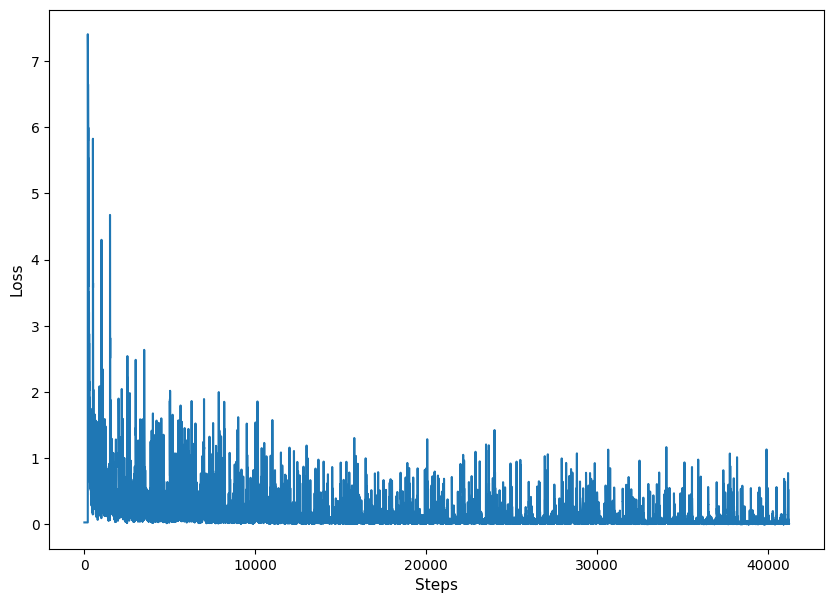

In [29]:
from collections import deque
epochs = 5000
losses = []
mem_size = 1000 #設定記憶串列的大小
batch_size = 200 #設定批次大小
replay = deque(maxlen=mem_size)
max_moves = 50
sync_freq = 500 #設定Q網路和目標網路的參數同步頻率（每500步就同步一次參數）
j=0 #記錄當前訓練次數
for i in range(epochs):
  game = Gridworld(size=4, mode='random')
  state1_ = game.board.render_np().reshape(1,64) + np.random.rand(1,64)/100.0
  state1 = torch.from_numpy(state1_).float()
  status = 1
  mov = 0
  while(status == 1): 
    j+=1 #將訓練次數加1
    mov += 1
    qval = model(state1)
    qval_ = qval.data.numpy()
    if (random.random() < epsilon):
      action_ = np.random.randint(0,4)
    else:
      action_ = np.argmax(qval_)
    action = action_set[action_]
    game.makeMove(action)
    state2_ = game.board.render_np().reshape(1,64) + np.random.rand(1,64)/100.0
    state2 = torch.from_numpy(state2_).float()
    reward = game.reward()
    done = True if reward != -1 else False
    exp =  (state1, action_, reward, state2, done)
    replay.append(exp) 
    state1 = state2      
    if len(replay) > batch_size:
      minibatch = random.sample(replay, batch_size)
      state1_batch = torch.cat([s1 for (s1,a,r,s2,d) in minibatch])
      action_batch = torch.Tensor([a for (s1,a,r,s2,d) in minibatch])
      reward_batch = torch.Tensor([r for (s1,a,r,s2,d) in minibatch])
      state2_batch = torch.cat([s2 for (s1,a,r,s2,d) in minibatch])
      done_batch = torch.Tensor([d for (s1,a,r,s2,d) in minibatch])
      Q1 = model(state1_batch) 
      with torch.no_grad():     #用目標網路模型計算Q值, 但不要優化模型的參數
        Q2 = model2(state2_batch) 
      Y = reward_batch + gamma * ((1-done_batch) * torch.max(Q2,dim=1)[0])
      X = Q1.gather(dim=1,index=action_batch.long().unsqueeze(dim=1)).squeeze()
      loss = loss_fn(X, Y.detach())
      print(i, loss.item())
      clear_output(wait=True)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()        
      if j % sync_freq == 0: #每500步，就將Q網路當前的參數複製一份給目標網路
        model2.load_state_dict(model.state_dict())
    if reward != -1 or mov > max_moves:
      status = 0 
      mov = 0
    losses.append(loss.item())  
  if epsilon > 0.1: 
    epsilon -= (1/epochs) #讓ε的值隨著訓練的進行而慢慢下降，直到0.1（還是要保留探索的動作）    
plt.figure(figsize=(10,7))
plt.plot(losses)
plt.xlabel("Steps",fontsize=11)
plt.ylabel("Loss",fontsize=11)

## 測試勝率

In [30]:
max_games = 1000
wins = 0
for i in range(max_games):
    win = test_model(model, mode='random')
    if win:
      wins += 1
win_perc = float(wins) / float(max_games)
print("Games played: {0}, # of wins: {1}".format(max_games,wins))
print("Win percentage: {}%".format(100.0*win_perc)) #顯示勝率

Initial State:
[['+' 'W' 'P' ' ']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']
 [' ' ' ' '-' ' ']]
Move #: 0; Taking action: l
[['+' 'W' 'P' ' ']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']
 [' ' ' ' '-' ' ']]
Move #: 1; Taking action: l
[['+' 'W' 'P' ' ']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']
 [' ' ' ' '-' ' ']]
Move #: 2; Taking action: l
[['+' 'W' 'P' ' ']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']
 [' ' ' ' '-' ' ']]
Move #: 3; Taking action: l
[['+' 'W' 'P' ' ']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']
 [' ' ' ' '-' ' ']]
Move #: 4; Taking action: l
[['+' 'W' 'P' ' ']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']
 [' ' ' ' '-' ' ']]
Move #: 5; Taking action: l
[['+' 'W' 'P' ' ']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']
 [' ' ' ' '-' ' ']]
Move #: 6; Taking action: l
[['+' 'W' 'P' ' ']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']
 [' ' ' ' '-' ' ']]
Move #: 7; Taking action: l
[['+' 'W' 'P' ' ']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']
 [' ' ' ' '-' ' ']]
Move #: 8; Taking action: l
[['+' 'W' 'P' ' ']
 [' ' ' ' ' ' ' ']
 [

# 程式 3.5 改良版 （加入『學習避免撞牆』機制）

Initial State:
[[' ' ' ' '-' ' ']
 [' ' ' ' ' ' ' ']
 ['+' ' ' 'W' ' ']
 ['P' ' ' ' ' ' ']]
Move #: 0; Taking action: u
[[' ' ' ' '-' ' ']
 [' ' ' ' ' ' ' ']
 ['+' ' ' 'W' ' ']
 [' ' ' ' ' ' ' ']]
Game won! Reward: 10
True
Initial State:
[[' ' 'W' ' ' '+']
 [' ' ' ' ' ' ' ']
 [' ' ' ' '-' ' ']
 [' ' ' ' 'P' ' ']]
Move #: 0; Taking action: l
[[' ' 'W' ' ' '+']
 [' ' ' ' ' ' ' ']
 [' ' ' ' '-' ' ']
 [' ' 'P' ' ' ' ']]
Move #: 1; Taking action: u
[[' ' 'W' ' ' '+']
 [' ' ' ' ' ' ' ']
 [' ' 'P' '-' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 2; Taking action: u
[[' ' 'W' ' ' '+']
 [' ' 'P' ' ' ' ']
 [' ' ' ' '-' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 3; Taking action: r
[[' ' 'W' ' ' '+']
 [' ' ' ' 'P' ' ']
 [' ' ' ' '-' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 4; Taking action: r
[[' ' 'W' ' ' '+']
 [' ' ' ' ' ' 'P']
 [' ' ' ' '-' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 5; Taking action: u
[[' ' 'W' ' ' '+']
 [' ' ' ' ' ' ' ']
 [' ' ' ' '-' ' ']
 [' ' ' ' ' ' ' ']]
Game won! Reward: 10
True
Initial State:
[[' ' ' ' ' ' 

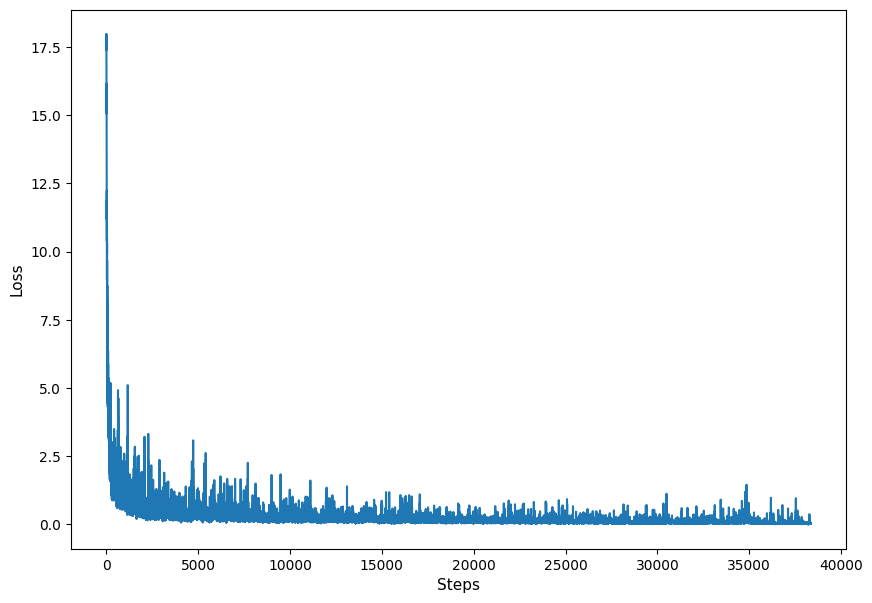

In [31]:
model = torch.nn.Sequential(
    torch.nn.Linear(L1, L2), #第一隱藏層
    torch.nn.ReLU(),
    torch.nn.Linear(L2, L3), #第二隱藏層
    torch.nn.ReLU(),
    torch.nn.Linear(L3,L4) #輸出層
)
loss_fn = torch.nn.MSELoss()
learning_rate = 1e-3  #超參數『α』
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) #model.parameters()會傳回所有要優化的權重參數

gamma = 0.9
epsilon = 1.0

#————————————————

from collections import deque
epochs = 5000
losses = []
mem_size = 1000 #設定記憶串列的大小
batch_size = 200 #設定單一小批次（mini_batch）的大小
move_pos = [(-1,0),(1,0),(0,-1),(0,1)]   #●移動方向 u,d,l,r 的實際移動向量 
replay = deque(maxlen=mem_size) #產生一個deque串列來儲存經驗回放的資料
max_moves = 50 #設定每場遊戲最多可以走幾步
for i in range(epochs):
  game = Gridworld(size=4, mode='random')
  state1_ = game.board.render_np().reshape(1,64) + np.random.rand(1,64)/100.0
  state1 = torch.from_numpy(state1_).float()
  status = 1
  mov = 0 #移動的步數
  while(status == 1): 
    mov += 1
    qval = model(state1) #輸出各動作的Q值
    qval_ = qval.data.numpy()
    if (random.random() < epsilon):
      action_ = np.random.randint(0,4)
    else:
      action_ = np.argmax(qval_)    
    hit_wall = game.validateMove('Player', move_pos[action_]) == 1 #●若有撞牆的動作，hit_wall就為True
    action = action_set[action_]
    game.makeMove(action)
    state2_ = game.board.render_np().reshape(1,64) + np.random.rand(1,64)/100.0
    state2 = torch.from_numpy(state2_).float()
    reward = -5 if hit_wall else game.reward() #●2.若撞牆回饋-5
    done = True if reward != -1 else False #在reward不等於-1時設定done=True，代表遊戲已經結束了（分出勝負時，reward會等於10或-10）
    exp = (state1, action_, reward, state2, done) #產生一筆經驗，其中包含當前狀態、動作、新狀態、回饋值及done值
    replay.append(exp) #將該經驗加入名為replay的deque串列中
    state1 = state2 #產生的新狀態會變成下一次訓練時的輸入狀態          
    if len(replay) > batch_size: #當replay的長度大於小批次量（mini-batch size）時，啟動小批次訓練
      minibatch = random.sample(replay, batch_size) #隨機選擇replay中的資料來組成子集
      state1_batch = torch.cat([s1 for (s1,a,r,s2,d) in minibatch]) #{5}將經驗中的不同元素分別儲存到對應的小批次張量中
      action_batch = torch.Tensor([a for (s1,a,r,s2,d) in minibatch])
      reward_batch = torch.Tensor([r for (s1,a,r,s2,d) in minibatch])
      state2_batch = torch.cat([s2 for (s1,a,r,s2,d) in minibatch]) 
      done_batch = torch.Tensor([d for (s1,a,r,s2,d) in minibatch])            
      Q1 = model(state1_batch) #利用小批次資料中的目前狀態來計算Q值
      with torch.no_grad():
        Q2 = model(state2_batch) #利用小批次資料中的新狀態來計算Q值，但設定為不需要計算梯度         
      Y = reward_batch + gamma * ((1 - done_batch) * torch.max(Q2,dim=1)[0]) #計算我們希望DQN學習的目標Q值
      X = Q1.gather(dim=1,index=action_batch.long().unsqueeze(dim=1)).squeeze() #gather()及unsqueeze()函式的用途可參見下面的小編補充框 
      loss = loss_fn(X, Y.detach())
      if i%100 == 0:
        print(i, loss.item())
        clear_output(wait=True)             
      optimizer.zero_grad()
      loss.backward()            
      losses.append(loss.item())
      optimizer.step()
    if abs(reward) == 10 or mov > max_moves:
      status = 0
      mov = 0 #若遊戲結束，則重設status和mov變數的值
  if epsilon > 0.1:
    epsilon -= (1/epochs) #讓ε的值隨著訓練的進行而慢慢下降，直到0.1（還是要保留探索的動作）
losses = np.array(losses)
plt.figure(figsize=(10,7))
plt.plot(losses)
plt.xlabel("Steps",fontsize=11)
plt.ylabel("Loss",fontsize=11)

#——————————————

max_games = 1000
wins = 0
for i in range(max_games):
  win = test_model(model, mode='random')
  if win:
    wins += 1
win_perc = float(wins) / float(max_games)
print("Games played: {0}, # of wins: {1}".format(max_games,wins))
print("Win percentage: {}%".format(100.0*win_perc)) #顯示勝率